In [1]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.metrics import brier_score_loss,precision_score,recall_score,f1_score
def plot_calibration_curve(est,X,y,idx_t,idx_v, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    
    X_train = X[idx_t]
    y_train = y[idx_t]
    X_val = X[idx_v]
    y_val = y[idx_v]
    cv = StratifiedShuffleSplit(n_splits=2,test_size=0.2,random_state=0)
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=cv, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=cv, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 16))
    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((6, 1), (2, 0))
    ax3 = plt.subplot2grid((6, 1), (3, 0))
    ax4 = plt.subplot2grid((6, 1), (4, 0))
    ax5 = plt.subplot2grid((6, 1), (5, 0))
    axes_list = [ax2,ax3,ax4,ax5]
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for i,(clf, name) in enumerate([(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_val)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_val)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_val, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_val, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_val, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_val, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_val, prob_pos, n_bins=8)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))
        axes_list[i].hist(prob_pos[y_val==0], range=(0, 1), bins=20, label='Normal',
                 histtype="stepfilled",alpha=0.5, lw=1,density=True)
        axes_list[i].hist(prob_pos[y_val==1], range=(0, 1), bins=20, label='Fraud',
                 histtype="stepfilled",alpha=0.5,  lw=1,density=True)
        axes_list[i].set_xlabel('Predicted probability')
        axes_list[i].set_ylabel('Density')
        axes_list[i].legend(loc="upper center", ncol=2)
        axes_list[i].set_title(name)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')



    plt.tight_layout()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import scipy
import sklearn
# plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("notebook")
DATA_PATH = '../data/'

VAL_SPLITS = 4

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH,'df_train.csv'))
df.drop(columns= df.columns[0:2],inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,TimeScaled,TimeSin,TimeCos,AmountBC
0,-0.829392,1.118573,0.926038,1.163686,0.009824,0.527347,0.173370,0.723997,-0.638939,-0.162923,...,-0.298908,-0.060301,-0.217935,0.291312,0.120779,0,0.460069,-0.480989,0.876727,3.195062
1,-2.814527,1.613321,0.654307,0.581821,0.399491,0.730040,0.456233,-2.464347,0.654797,2.248682,...,-0.329526,-0.307374,-0.440007,-2.135657,0.011041,0,0.266395,-0.204567,-0.978853,3.125269
2,2.105028,-0.700400,-1.338043,-0.596395,-0.395217,-0.755050,-0.276951,-0.291562,-0.965418,1.107179,...,-0.278137,-0.040685,0.789267,-0.066054,-0.069956,0,0.762303,-0.153992,-0.988072,3.421235
3,2.205839,-1.023897,-1.270137,-0.950174,-0.868712,-0.975492,-0.475464,-0.280564,0.503713,0.448173,...,-0.041177,0.089158,1.105794,-0.066285,-0.079881,0,0.879740,-0.998227,0.059524,1.072145
4,2.027090,-0.778666,-1.552755,-0.558679,0.020939,-0.026071,-0.207810,-0.124288,-0.635953,0.817757,...,0.033477,-0.157992,-0.606327,-0.003931,-0.039868,0,0.821649,-0.783558,-0.621319,3.971490


Logistic:
	Brier: 0.001
	Precision: 0.860
	Recall: 0.463
	F1: 0.602

AdaBoost:
	Brier: 0.205
	Precision: 0.841
	Recall: 0.463
	F1: 0.597

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.804
	Recall: 0.562
	F1: 0.662

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.857
	Recall: 0.450
	F1: 0.590

1-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.875
	Recall: 0.525
	F1: 0.656

AdaBoost:
	Brier: 0.205
	Precision: 0.750
	Recall: 0.562
	F1: 0.643

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.763
	Recall: 0.562
	F1: 0.647

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.776
	Recall: 0.562
	F1: 0.652

2-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.837
	Recall: 0.450
	F1: 0.585

AdaBoost:
	Brier: 0.204
	Precision: 0.795
	Recall: 0.438
	F1: 0.565

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.778
	Recall: 0.525
	F1: 0.627

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.854
	Recall: 0.512
	F1: 0.641

3-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.857
	

/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


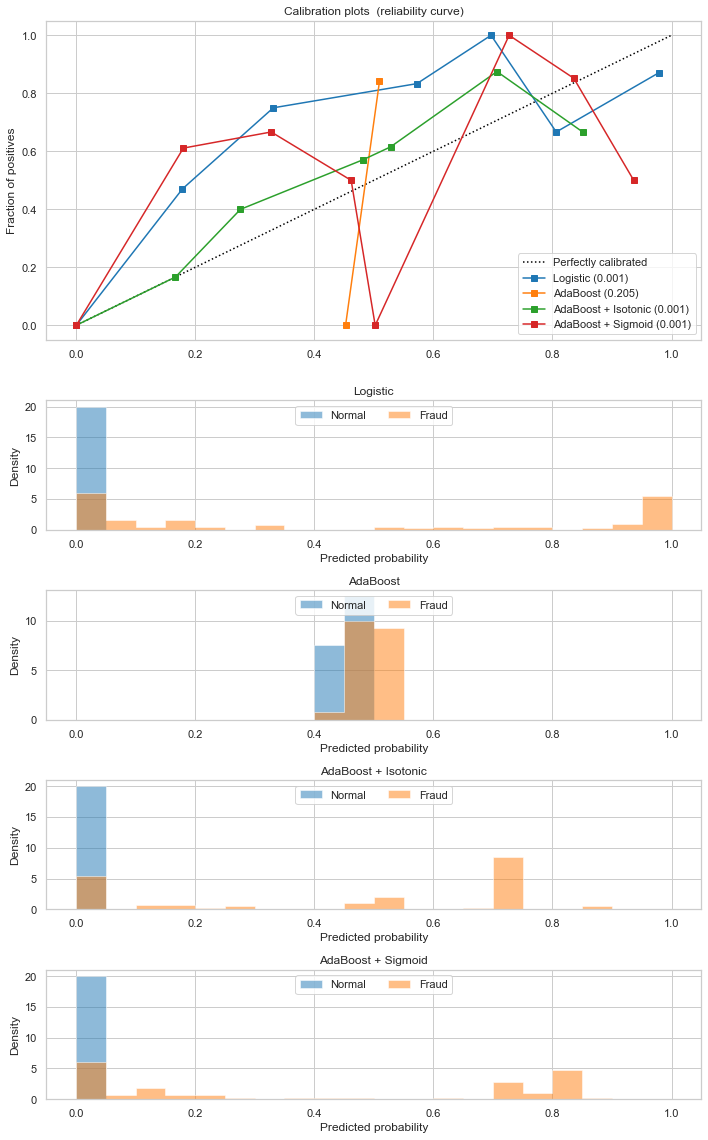

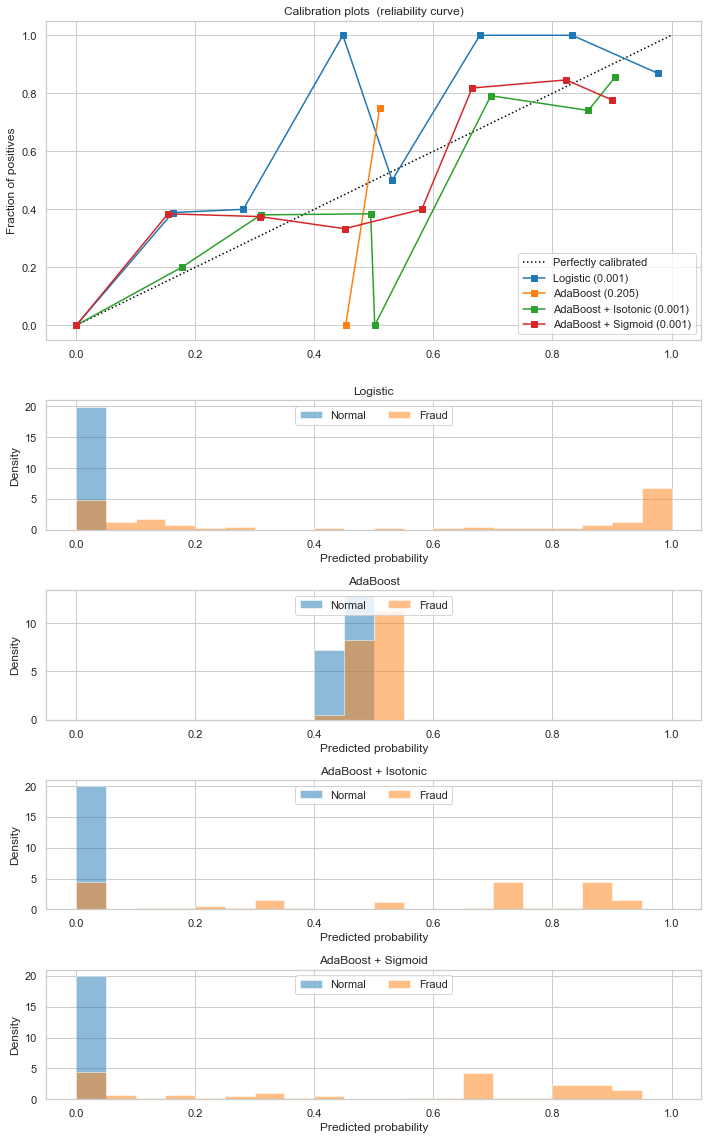

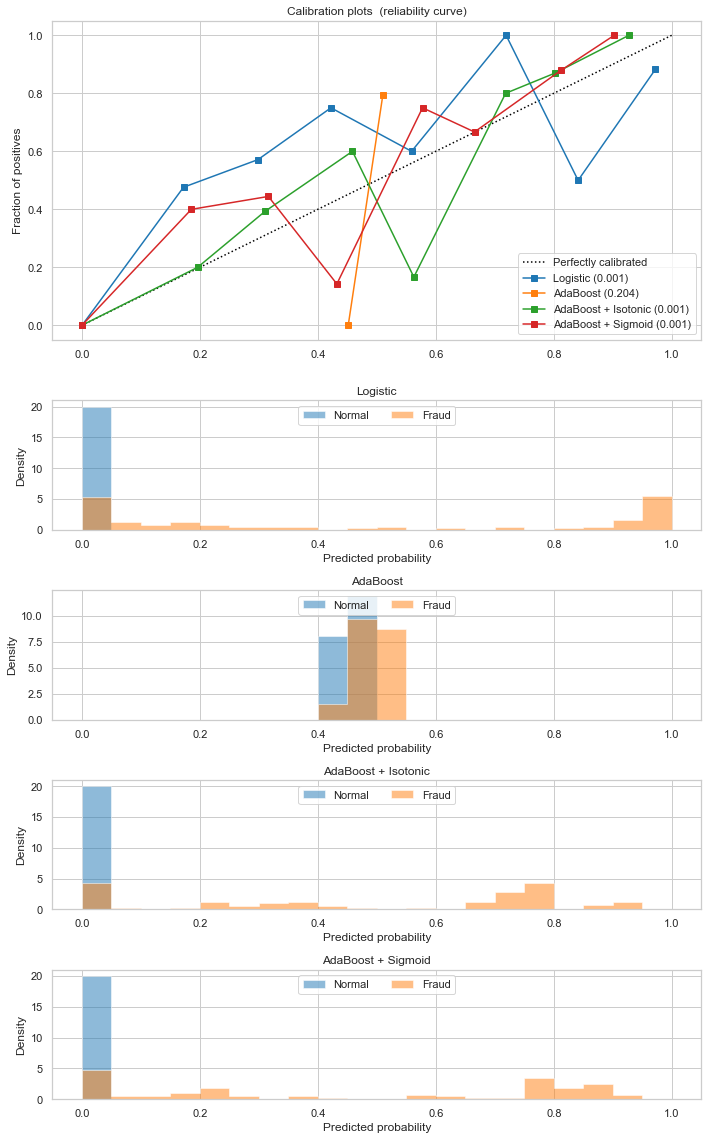

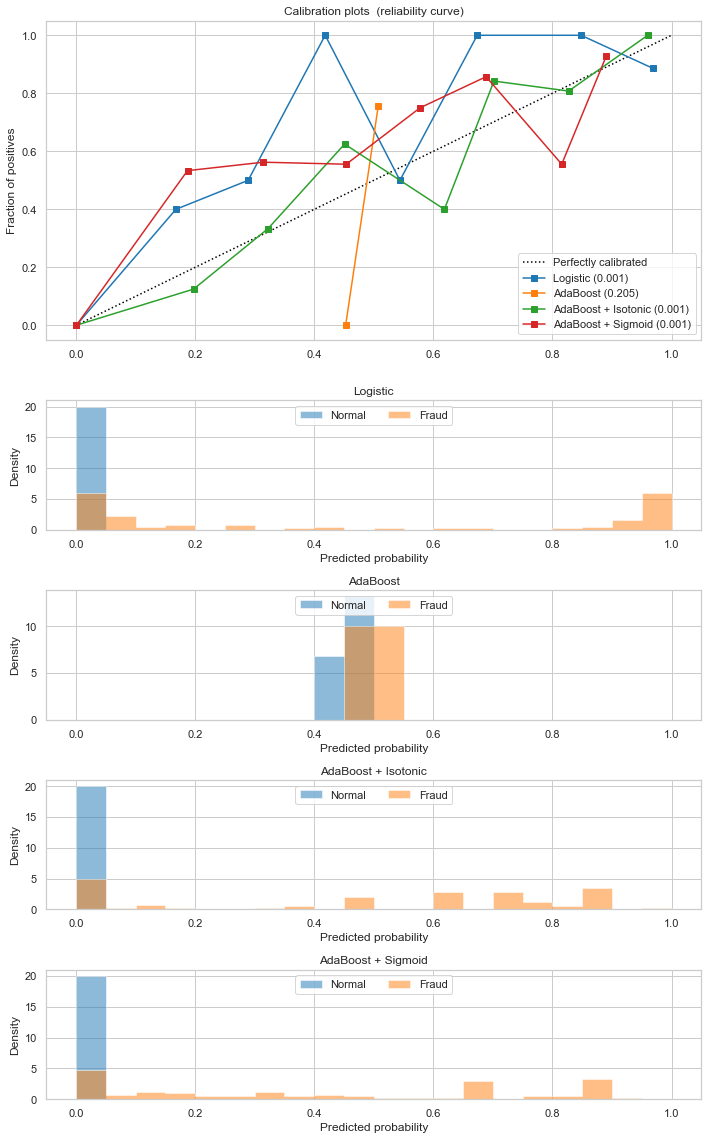

In [52]:
val_split = StratifiedShuffleSplit(n_splits=VAL_SPLITS,test_size=0.20,random_state=0)
clf = AdaBoostClassifier()

metrics = []
metrics_train = []
df_ = df[['Class','V6','V14','V16']]
X = df_.drop(columns='Class').to_numpy()
y = df_['Class'].to_numpy()
for i,(idx_t, idx_v) in enumerate(val_split.split(X,y)):
    X_train = X[idx_t]
    y_train = y[idx_t]
    X_val = X[idx_v]
    y_val = y[idx_v]
    
    plot_calibration_curve(clf,X,y,idx_t,idx_v,'AdaBoost',None)
    print('{}-fold / {} completed!'.format(i+1,VAL_SPLITS))
    
#     break
metric_mean = np.mean(metrics)
metric_std = np.std(metrics, ddof=1)
metric_t_mean = np.mean(metrics_train)
metric_t_std = np.std(metrics_train, ddof=1)
print('Metric value (Train): {:.2f} ± {:.2f}'.format(metric_t_mean,metric_t_std))
print('Metric value(Val): {:.2f} ± {:.2f}'.format(metric_mean,metric_std))

Logistic:
	Brier: 0.001
	Precision: 0.860
	Recall: 0.463
	F1: 0.602

AdaBoost:
	Brier: 0.001
	Precision: 0.867
	Recall: 0.650
	F1: 0.743

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.850
	Recall: 0.637
	F1: 0.729

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.862
	Recall: 0.625
	F1: 0.725

1-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.875
	Recall: 0.525
	F1: 0.656

AdaBoost:
	Brier: 0.001
	Precision: 0.900
	Recall: 0.675
	F1: 0.771

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.857
	Recall: 0.675
	F1: 0.755

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.900
	Recall: 0.675
	F1: 0.771

2-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.837
	Recall: 0.450
	F1: 0.585

AdaBoost:
	Brier: 0.001
	Precision: 0.905
	Recall: 0.713
	F1: 0.797

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.903
	Recall: 0.700
	F1: 0.789

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.917
	Recall: 0.688
	F1: 0.786

3-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.857
	

/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


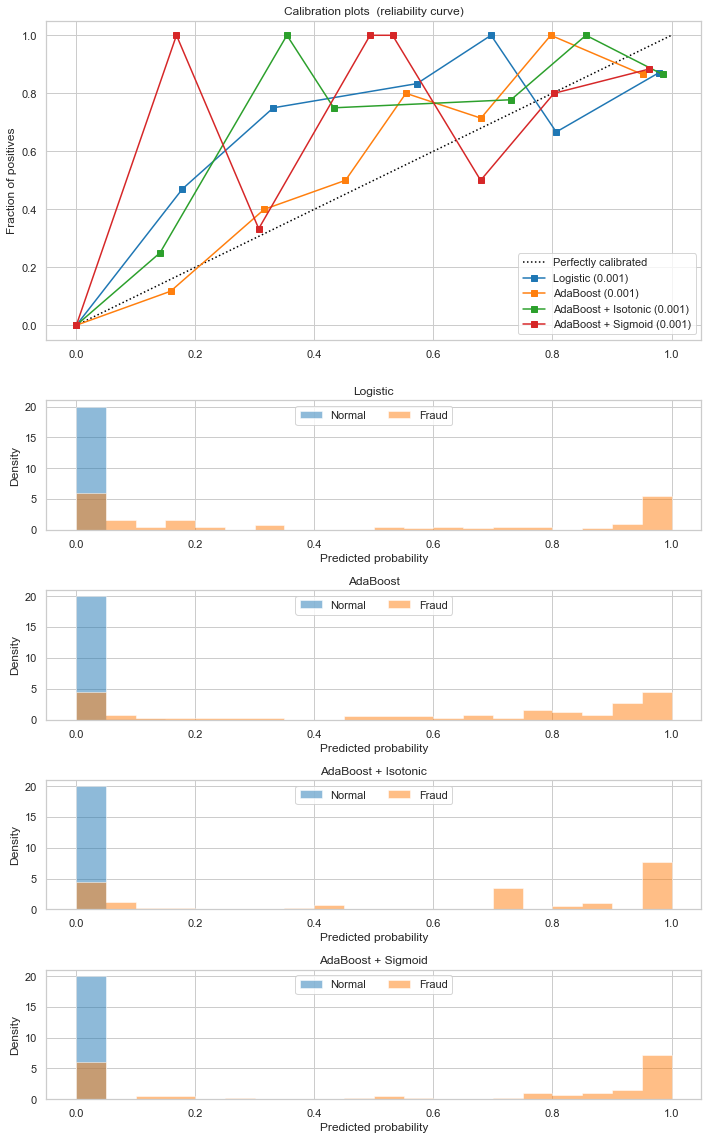

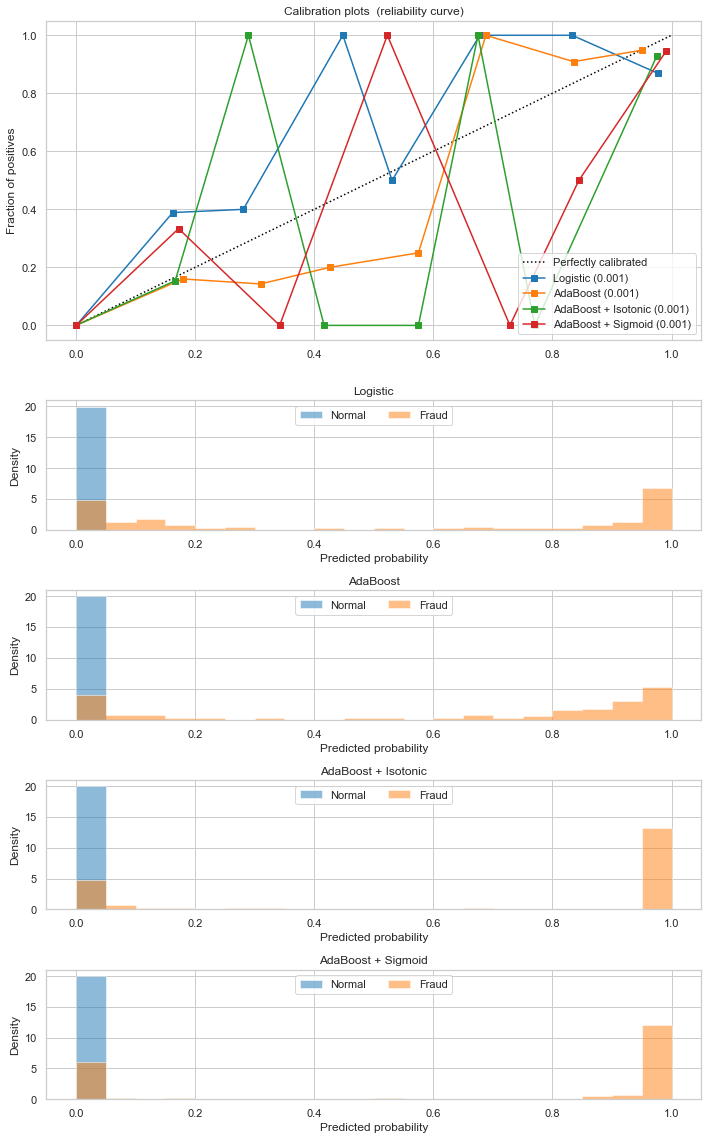

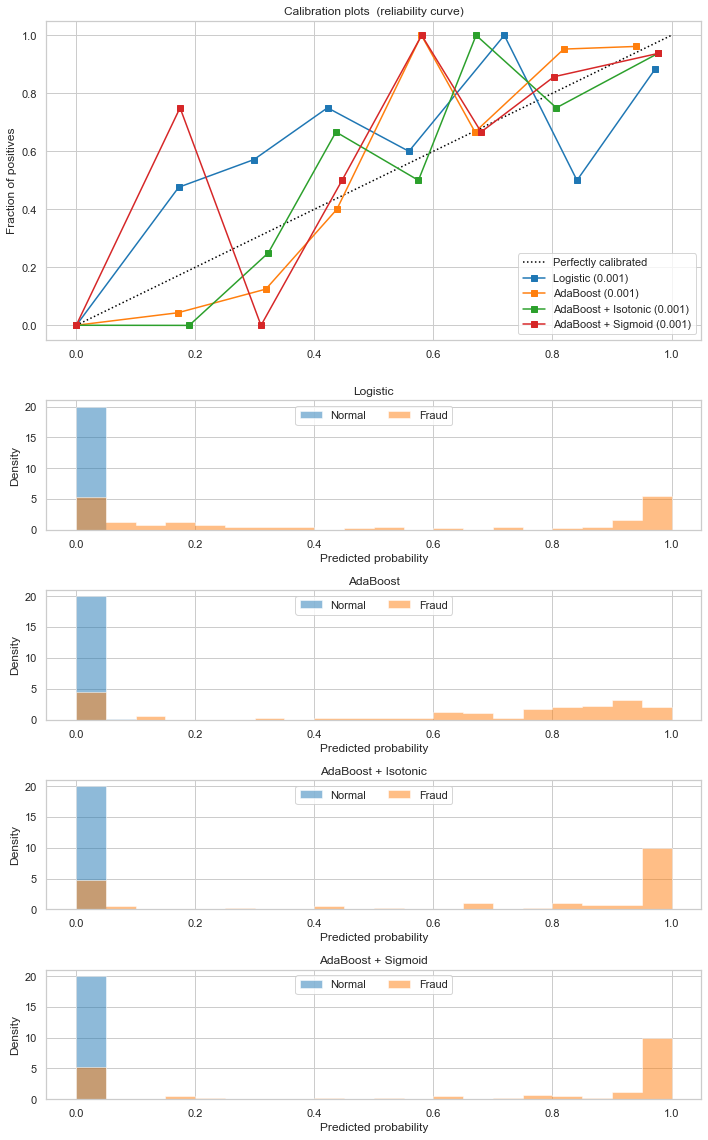

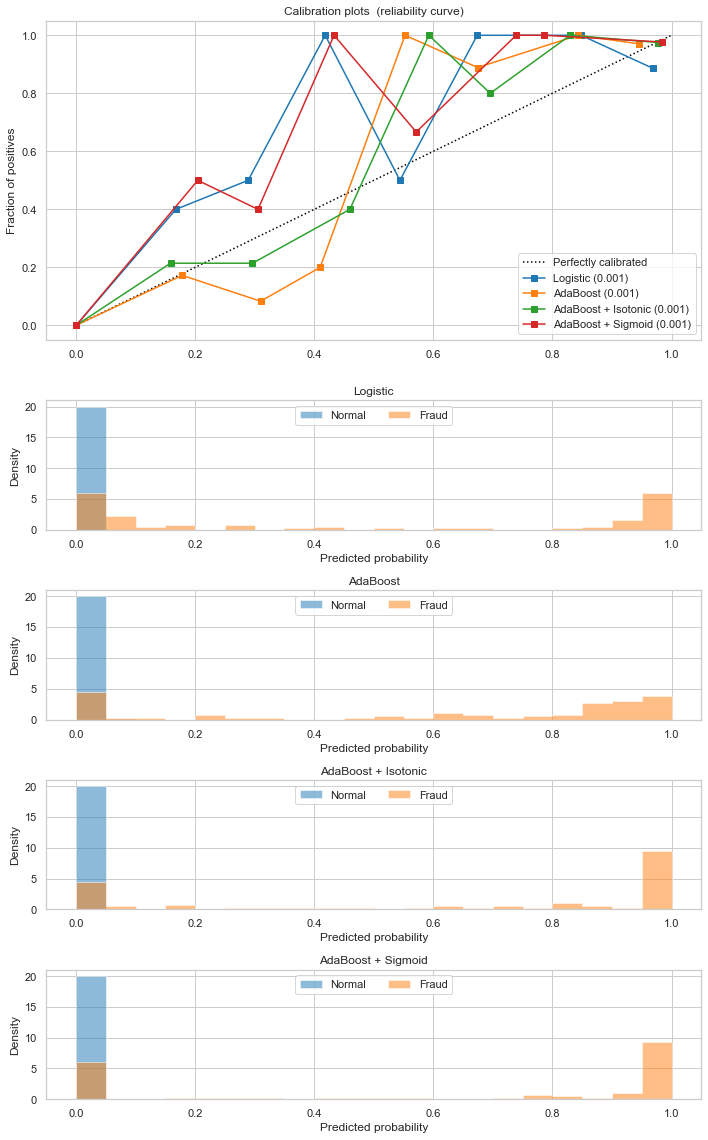

In [53]:
val_split = StratifiedShuffleSplit(n_splits=VAL_SPLITS,test_size=0.20,random_state=0)
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=0,class_weight=None)

metrics = []
metrics_train = []
df_ = df[['Class','V6','V14','V16']]
X = df_.drop(columns='Class').to_numpy()
y = df_['Class'].to_numpy()
for i,(idx_t, idx_v) in enumerate(val_split.split(X,y)):
    X_train = X[idx_t]
    y_train = y[idx_t]
    X_val = X[idx_v]
    y_val = y[idx_v]
    
    plot_calibration_curve(clf,X,y,idx_t,idx_v,'AdaBoost',None)
    print('{}-fold / {} completed!'.format(i+1,VAL_SPLITS))
    
#     break
metric_mean = np.mean(metrics)
metric_std = np.std(metrics, ddof=1)
metric_t_mean = np.mean(metrics_train)
metric_t_std = np.std(metrics_train, ddof=1)
print('Metric value (Train): {:.2f} ± {:.2f}'.format(metric_t_mean,metric_t_std))
print('Metric value(Val): {:.2f} ± {:.2f}'.format(metric_mean,metric_std))

Logistic:
	Brier: 0.001
	Precision: 0.860
	Recall: 0.463
	F1: 0.602

AdaBoost:
	Brier: 0.001
	Precision: 0.877
	Recall: 0.625
	F1: 0.730

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.862
	Recall: 0.625
	F1: 0.725

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.860
	Recall: 0.613
	F1: 0.715

1-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.875
	Recall: 0.525
	F1: 0.656

AdaBoost:
	Brier: 0.001
	Precision: 0.900
	Recall: 0.675
	F1: 0.771

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.846
	Recall: 0.688
	F1: 0.759

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.902
	Recall: 0.688
	F1: 0.780

2-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.837
	Recall: 0.450
	F1: 0.585

AdaBoost:
	Brier: 0.001
	Precision: 0.902
	Recall: 0.688
	F1: 0.780

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.873
	Recall: 0.688
	F1: 0.769

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.900
	Recall: 0.675
	F1: 0.771

3-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.857
	

/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


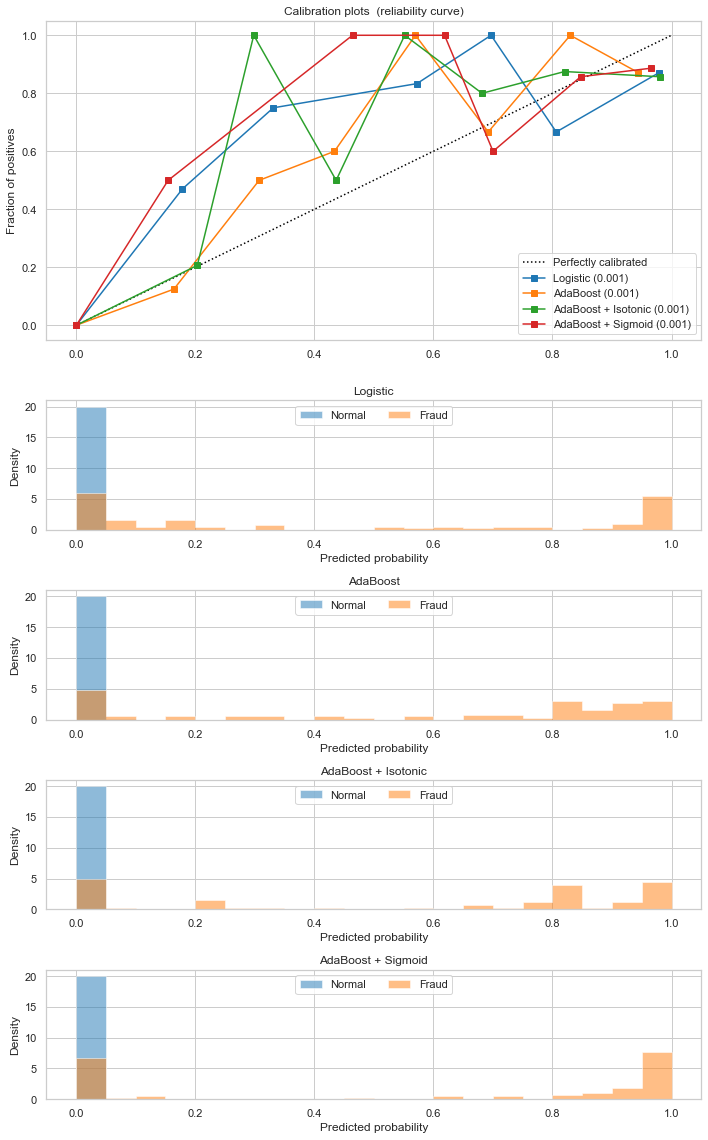

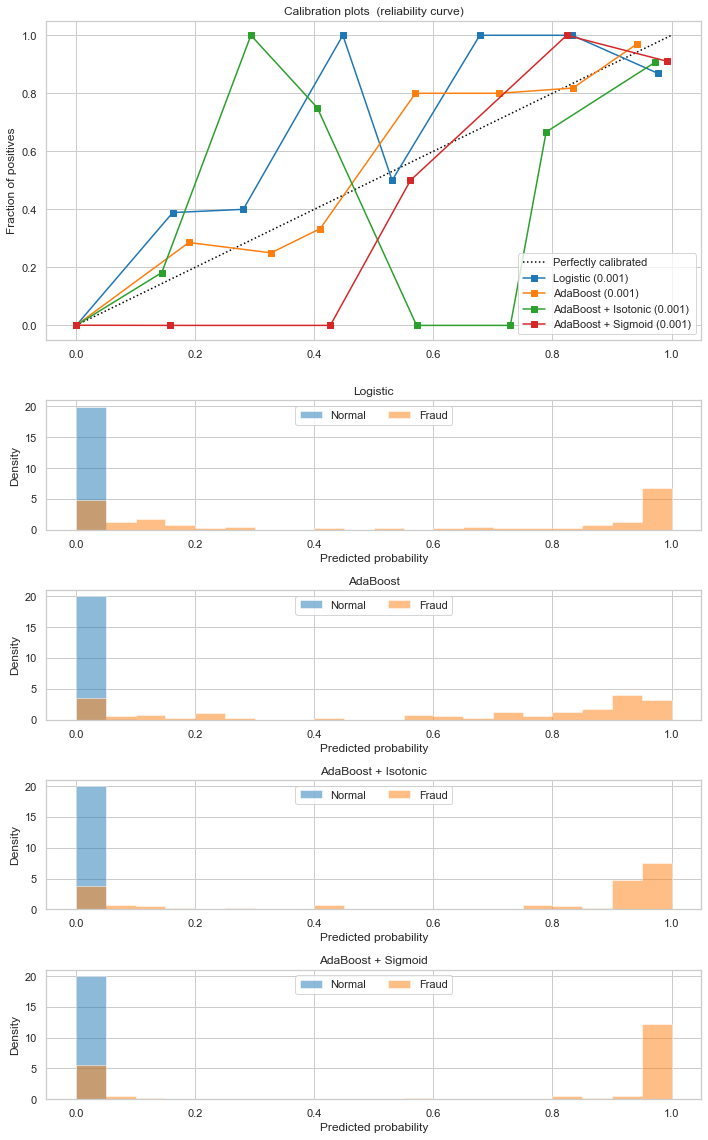

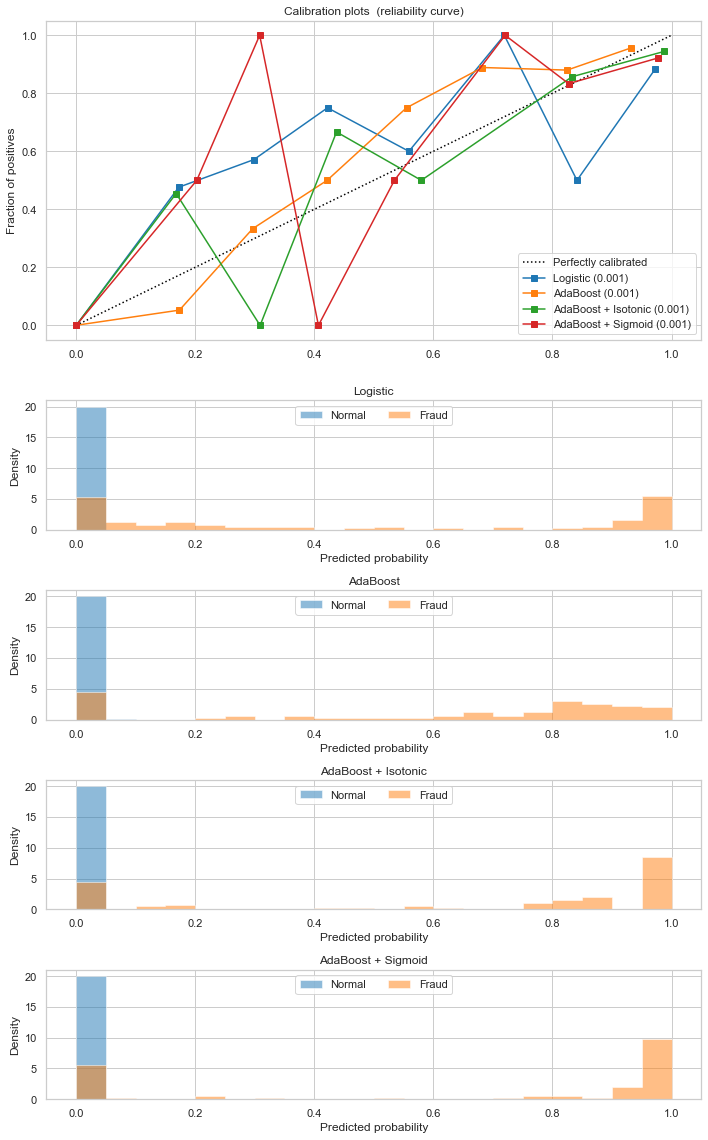

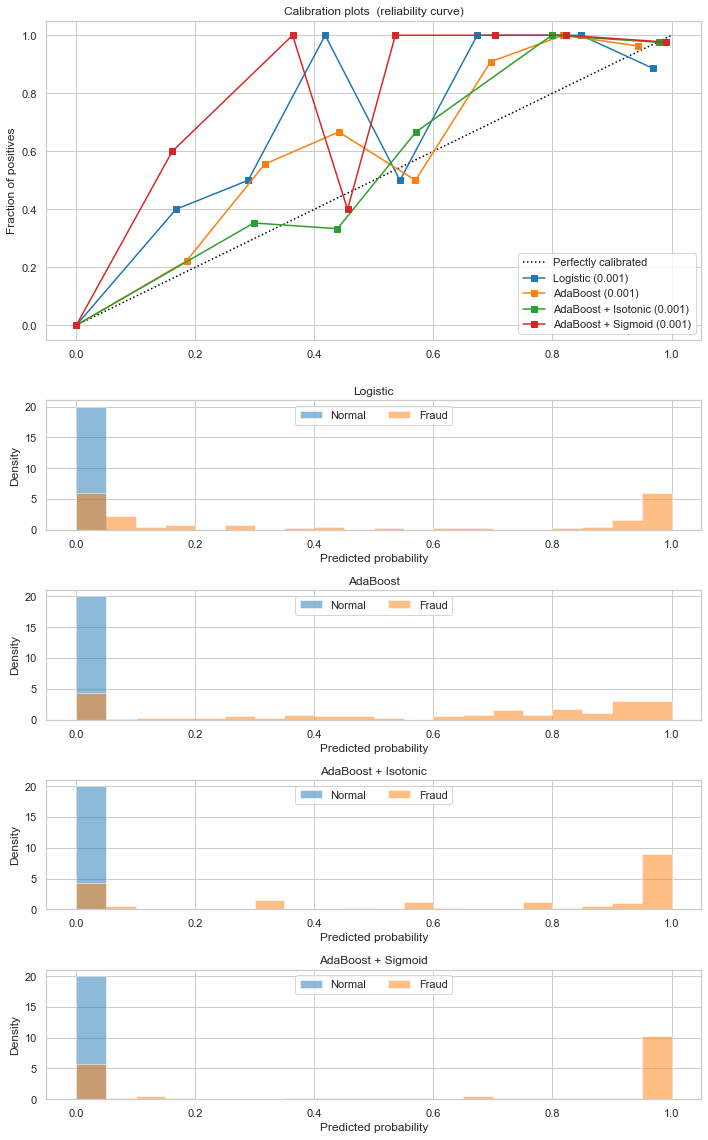

In [54]:
val_split = StratifiedShuffleSplit(n_splits=VAL_SPLITS,test_size=0.20,random_state=0)
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=0,class_weight='balanced_subsample')

metrics = []
metrics_train = []
df_ = df[['Class','V6','V14','V16']]
X = df_.drop(columns='Class').to_numpy()
y = df_['Class'].to_numpy()
for i,(idx_t, idx_v) in enumerate(val_split.split(X,y)):
    X_train = X[idx_t]
    y_train = y[idx_t]
    X_val = X[idx_v]
    y_val = y[idx_v]
    
    plot_calibration_curve(clf,X,y,idx_t,idx_v,'AdaBoost',None)
    print('{}-fold / {} completed!'.format(i+1,VAL_SPLITS))
    
#     break
metric_mean = np.mean(metrics)
metric_std = np.std(metrics, ddof=1)
metric_t_mean = np.mean(metrics_train)
metric_t_std = np.std(metrics_train, ddof=1)
print('Metric value (Train): {:.2f} ± {:.2f}'.format(metric_t_mean,metric_t_std))
print('Metric value(Val): {:.2f} ± {:.2f}'.format(metric_mean,metric_std))

Logistic:
	Brier: 0.001
	Precision: 0.860
	Recall: 0.463
	F1: 0.602

AdaBoost:
	Brier: 0.001
	Precision: 0.877
	Recall: 0.625
	F1: 0.730

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.862
	Recall: 0.625
	F1: 0.725

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.857
	Recall: 0.600
	F1: 0.706

1-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.875
	Recall: 0.525
	F1: 0.656

AdaBoost:
	Brier: 0.001
	Precision: 0.915
	Recall: 0.675
	F1: 0.777

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.846
	Recall: 0.688
	F1: 0.759

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.873
	Recall: 0.688
	F1: 0.769

2-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.837
	Recall: 0.450
	F1: 0.585

AdaBoost:
	Brier: 0.001
	Precision: 0.900
	Recall: 0.675
	F1: 0.771

AdaBoost + Isotonic:
	Brier: 0.001
	Precision: 0.877
	Recall: 0.713
	F1: 0.786

AdaBoost + Sigmoid:
	Brier: 0.001
	Precision: 0.898
	Recall: 0.662
	F1: 0.763

3-fold / 4 completed!
Logistic:
	Brier: 0.001
	Precision: 0.857
	

/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


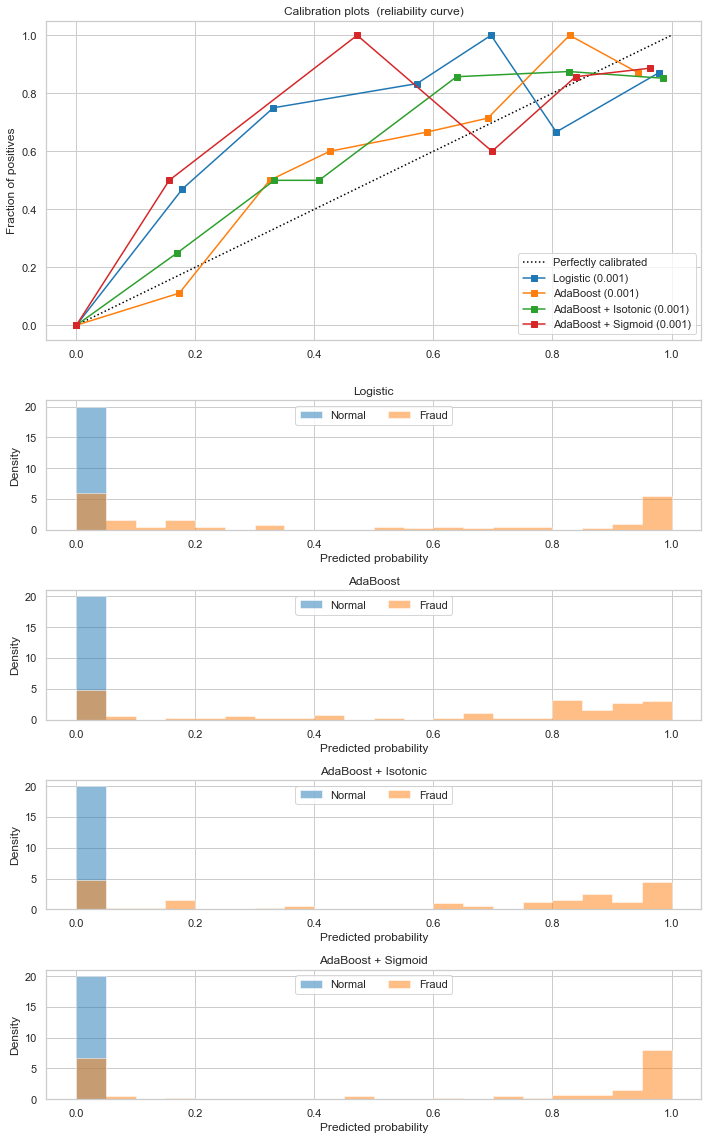

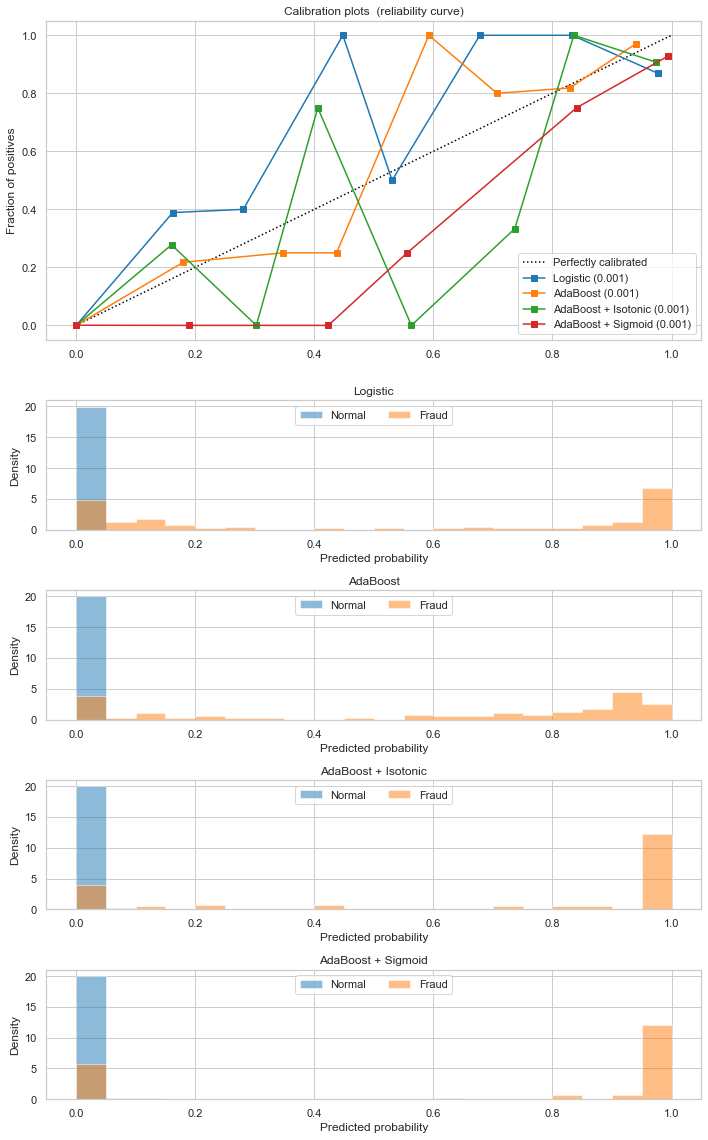

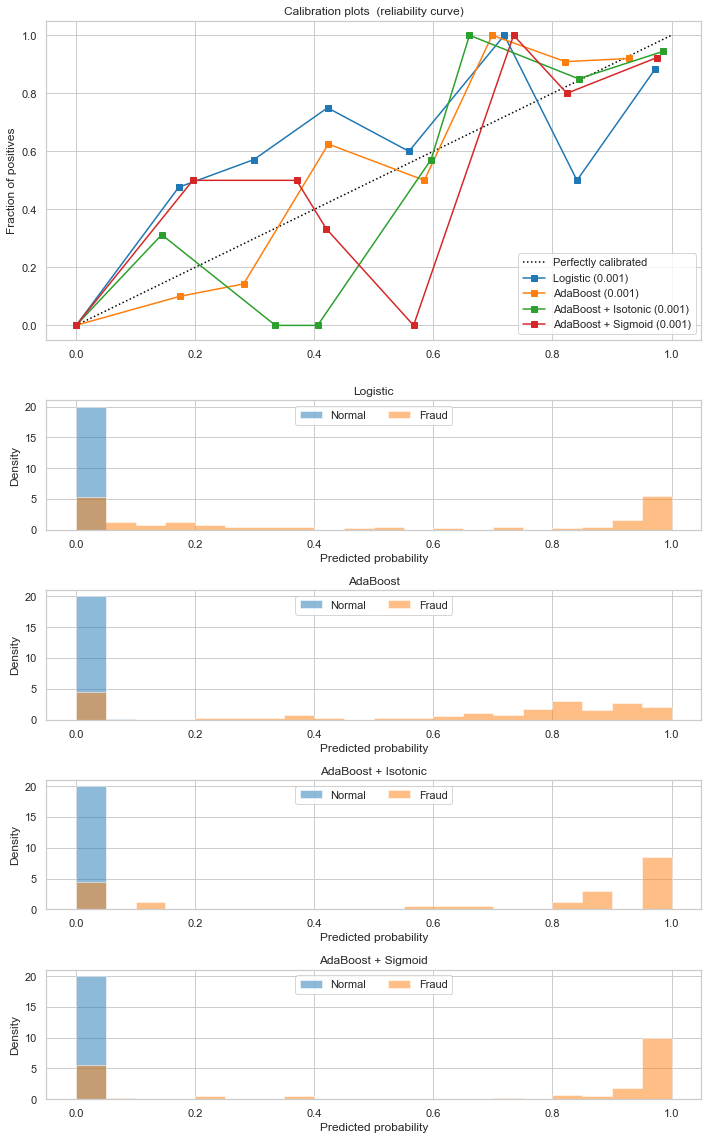

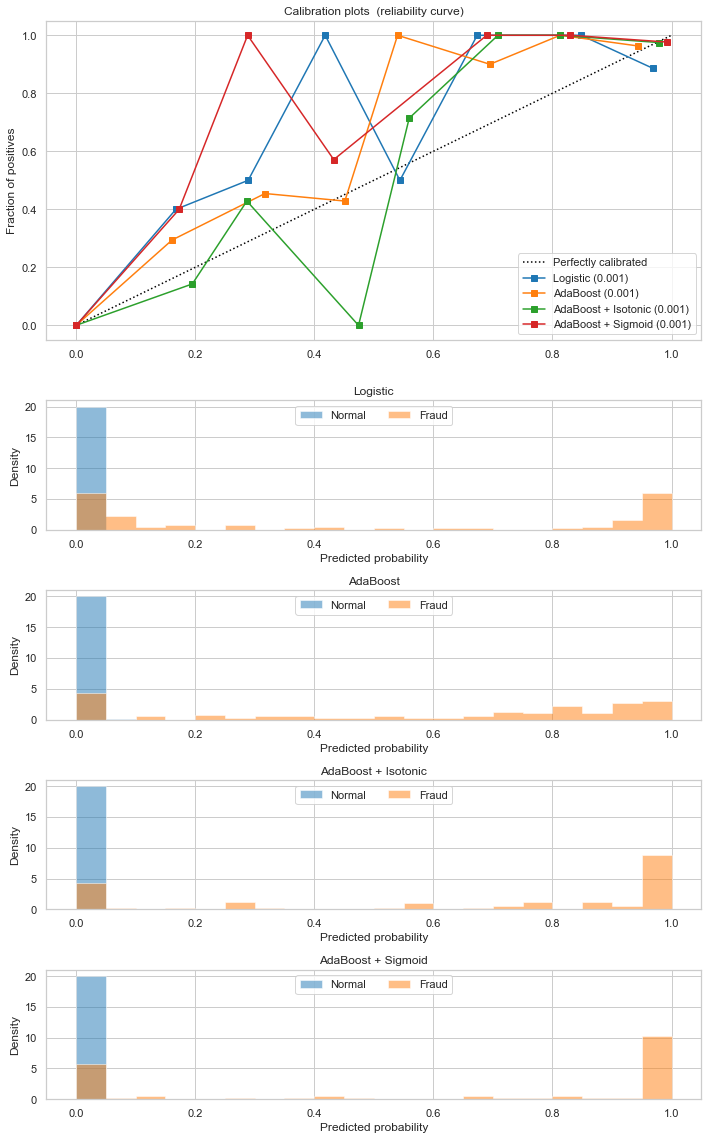

In [55]:
val_split = StratifiedShuffleSplit(n_splits=VAL_SPLITS,test_size=0.20,random_state=0)
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=0,class_weight='balanced')

metrics = []
metrics_train = []
df_ = df[['Class','V6','V14','V16']]
X = df_.drop(columns='Class').to_numpy()
y = df_['Class'].to_numpy()
for i,(idx_t, idx_v) in enumerate(val_split.split(X,y)):
    X_train = X[idx_t]
    y_train = y[idx_t]
    X_val = X[idx_v]
    y_val = y[idx_v]
    
    plot_calibration_curve(clf,X,y,idx_t,idx_v,'AdaBoost',None)
    print('{}-fold / {} completed!'.format(i+1,VAL_SPLITS))
    
#     break
metric_mean = np.mean(metrics)
metric_std = np.std(metrics, ddof=1)
metric_t_mean = np.mean(metrics_train)
metric_t_std = np.std(metrics_train, ddof=1)
print('Metric value (Train): {:.2f} ± {:.2f}'.format(metric_t_mean,metric_t_std))
print('Metric value(Val): {:.2f} ± {:.2f}'.format(metric_mean,metric_std))